# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 8. Generative Adversarial Networks

### Практическое задание

Обучить генератор создавать точки, которые будут лежать на графике функции

    y = sin(x)/x - x/10

При выполнении данного задания структура GAN остается той же, но Вам нужно:
1. Сгенерировать настоящие данные
2. Изменить архитектуру дискриминатора и генератора
3. Построить графики

### Решение

#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

from IPython import display

#### Настройки проекта

In [2]:
# Случайное зерно.
GLOBAL__RANDOM_STATE = 0

# Выбор устройства.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Подготовка данных для Дискриминатора

In [3]:
# Целевая функция.
def f(x):
    return np.sin(x)/x - x/10

In [4]:
# Проверка работы функции.
f(1)

0.7414709848078965

In [5]:
# Создание датасета с 1000 объектов.
# Координата "x" выбрана случайно в интервале [-10; 10).
df_d = pd.DataFrame(((np.random.rand(1, 1000) - 0.5) * 40).T, columns=['x'])

In [6]:
# Расчёт координаты "y" согласно функции.
df_d['y'] = df_d['x'].apply(lambda x: f(x))

In [7]:
# Проверка: вывод первых пяти строк датасета.
df_d.head()

,x,y
0,-4.150504,0.211159
1,-1.022784,0.936826
2,7.616248,-0.634019
3,8.152234,-0.697973
4,3.845568,-0.552868


In [8]:
# Проверка: вывод основной информации о датасете.
df_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1000 non-null   float64
 1   y       1000 non-null   float64
dtypes: float64(2)
memory usage: 15.8 KB


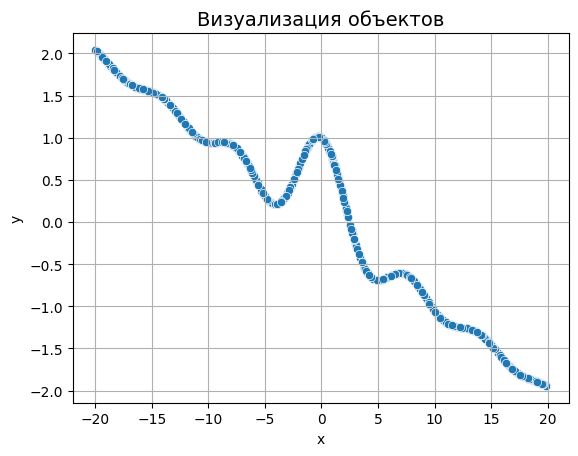

In [9]:
# Визуализация объектов.
sns.scatterplot(
    x=df_d['x'],
    y=df_d['y']
)

plt.grid()

plt.title('Визуализация объектов', fontdict={'size': 14});

In [10]:
# Класс датасета.
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        
        self.data = torch.from_numpy(data).float()
        
        if target is not None:
            self.target = torch.from_numpy(target).int()
        else:
            self.target = None
        
        self.transform = transform
    
    
    def __getitem__(self, index):
        
        x = self.data[index]
        
        if self.target is not None:
            y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        if self.target is not None:
            return x, y
        
        return x
    
    
    def __len__(self):
        return len(self.data)

In [11]:
# Инициализация датасета для Дискриминатора.
dw_d = DataWrapper(data=df_d.values)

In [12]:
# Инициализация загрузчика данных для Дискриминатора.
dl_d = DataLoader(dw_d, batch_size=10, shuffle=True)

In [13]:
# Проверка загрузчика для Дискриминатора.
for x in dl_d:
    print(f'Размерность тензора объекта:\t{x[0].shape}')
    print(f'Тензор:\n\t{x[0]}')
    break

Размерность тензора объекта:	torch.Size([2])
Тензор:
	tensor([18.2977, -1.8584])


#### Подготовка данных для Генератора

In [14]:
# Создание датасета с 1000 объектов случайного шума.
df_g = pd.DataFrame(((np.random.rand(4, 1000) - 0.5) * 20).T, columns=['noise_1', 'noise_2', 'noise_3', 'noise_4'])

In [15]:
# Проверка: вывод первых пяти строк датасета.
df_g.head()

,noise_1,noise_2,noise_3,noise_4
0,2.628315,-8.006042,-1.877868,-3.661106
1,-2.056462,7.652527,-1.164330,-5.013226
2,5.980428,5.068354,6.931037,-6.828728
3,5.622829,-1.525013,9.886693,1.444792
4,-7.975674,-0.294007,2.994539,4.725127


In [16]:
# Проверка: вывод основной информации о датасете.
df_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   noise_1  1000 non-null   float64
 1   noise_2  1000 non-null   float64
 2   noise_3  1000 non-null   float64
 3   noise_4  1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB


In [17]:
# Инициализация датасета для Генератора.
dw_g = DataWrapper(data=df_g.values)

In [18]:
# Инициализация загрузчика данных для Генератора.
dl_g = DataLoader(dw_g, batch_size=10, shuffle=True)

In [19]:
# Проверка загрузчика для Генератора.
for x in dl_g:
    print(f'Размерность тензора объекта:\t{x[0].shape}')
    print(f'Тензор:\n\t{x[0]}')
    break

Размерность тензора объекта:	torch.Size([4])
Тензор:
	tensor([-1.3836,  5.1421, -9.2398, -4.1863])


#### Генератор

In [20]:
# Класс Генератора.
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_1 = nn.Linear(in_features=4, out_features=20)
        self.drop_out_1 = nn.Dropout1d(p = 0.1)
        self.batch_norm_1 = nn.BatchNorm1d(num_features=20)
        self.leaky_relu_1 = nn.LeakyReLU(negative_slope=0.1)
        
        self.linear_2 = nn.Linear(in_features=20, out_features=20)
        self.drop_out_2 = nn.Dropout1d(p = 0.1)
        self.batch_norm_2 = nn.BatchNorm1d(num_features=20)
        self.leaky_relu_2 = nn.LeakyReLU(negative_slope=0.1)
        
        self.linear_3 = nn.Linear(in_features=20, out_features=10)
        self.leaky_relu_3 = nn.LeakyReLU(negative_slope=0.1)
        
        self.linear_4 = nn.Linear(in_features=10, out_features=5)
        self.leaky_relu_4 = nn.LeakyReLU(negative_slope=0.1)
        
        self.linear_5 = nn.Linear(in_features=5, out_features=2)
        self.leaky_relu_5 = nn.LeakyReLU(negative_slope=0.1)
    

    def forward(self, x):
        x = self.linear_1(x)
        x = self.drop_out_1(x)
        x = self.batch_norm_1(x)
        x = self.leaky_relu_1(x)
        
        x = self.linear_2(x)
        x = self.drop_out_2(x)
        x = self.batch_norm_2(x)
        x = self.leaky_relu_2(x)
        
        x = self.linear_3(x)
        x = self.leaky_relu_3(x)
        
        x = self.linear_4(x)
        x = self.leaky_relu_4(x)
        
        x = self.linear_5(x)
        x = self.leaky_relu_5(x)
        
        return x

#### Дискриминатор

In [21]:
# Класс Дискриминатора.
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_1 = nn.Linear(in_features=2, out_features=10)
        self.leaky_relu_1 = nn.LeakyReLU(negative_slope=0.1)
        
        self.linear_2 = nn.Linear(in_features=10, out_features=10)
        self.leaky_relu_2 = nn.LeakyReLU(negative_slope=0.1)
        
        self.linear_3 = nn.Linear(in_features=10, out_features=1)
        self.sigmoid_3 = nn.Sigmoid()
    

    def forward(self, x):
        x = self.linear_1(x)
        x = self.leaky_relu_1(x)
        
        x = self.linear_2(x)
        x = self.leaky_relu_2(x)
        
        x = self.linear_3(x)
        x = self.sigmoid_3(x)
        
        return x

#### Обучение Дискриминатора и Генератора

Далее идёт код из методички с небольшими изменениями.

In [22]:
# n_epochs = 20  # количество эпох
n_epochs = 100  # количество эпох
lr = 0.0002  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

# latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору
latent_dim = 4  # Размерность случайного вектора, который подается на вход генератору

# sample_interval = 500  # количество итераций для отображения процесса обучения
sample_interval = 100  # количество итераций для отображения процесса обучения

# batch_size = 50
batch_size = 10

In [23]:
# Инициализация Генератора и Дискриминатора.
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Оптимизаторы Генератора и Дискриминатора.
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Функция потерь - кросс-энтропия.
adversarial_loss = torch.nn.BCELoss()

In [24]:
# Массивы для подсчёта функций потерь.
d_loss_history = []
g_loss_history = []

# Массив для визуализации финального прогноза Генератора.
final_data = None

[Epoch 100/100] [Batch 0/10]|[D loss: 0.6958156824111938] [G loss: 0.6871775984764099]


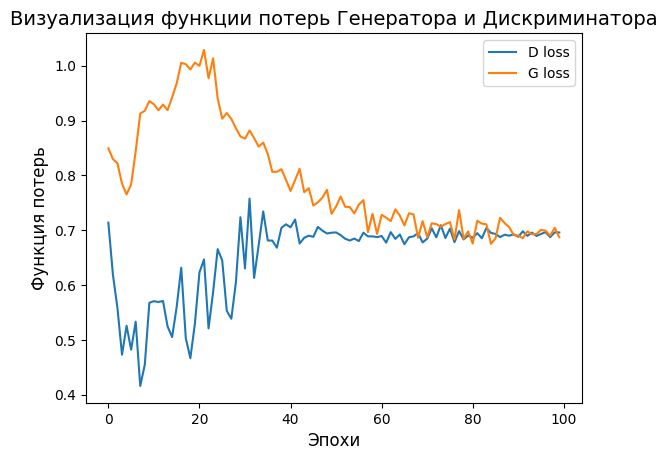

CPU times: total: 5min 9s
Wall time: 39.5 s


In [25]:
%%time


for epoch in range(n_epochs):
#     for i, (imgs, labels) in enumerate(real_data):
    for i, real_data in enumerate(dl_d):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

#         real_imgs = imgs.type(torch.FloatTensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
#         gen_imgs = generator(z)
        gen_data = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
#         real_pred = discriminator(real_imgs)
        real_pred = discriminator(real_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
#         fake_pred = discriminator(gen_imgs)
        fake_pred = discriminator(gen_data)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
#         gen_imgs = generator(z)
        gen_data = generator(z)
        
        # Запись финального прогноза Генератора.
        if epoch + 1 == n_epochs:
            if final_data is None:
                final_data = gen_data.detach().numpy()
            else:
                final_data = np.concatenate((final_data, gen_data.detach().numpy()))

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
#         batches_done = epoch * len(real_data) + i
        batches_done = epoch * len(dl_d) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
#                 sample_image(gen_imgs)
                print(f"[Epoch {epoch + 1}/{n_epochs}] [Batch {i}/{len(real_data)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 


                # display.display(plt.gcf())
#                 plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                
                plt.title('Визуализация функции потерь Генератора и Дискриминатора', fontdict={'size': 14})
                plt.xlabel('Эпохи', fontdict={'size': 12})
                plt.ylabel('Функция потерь', fontdict={'size': 12})
                
                plt.show();

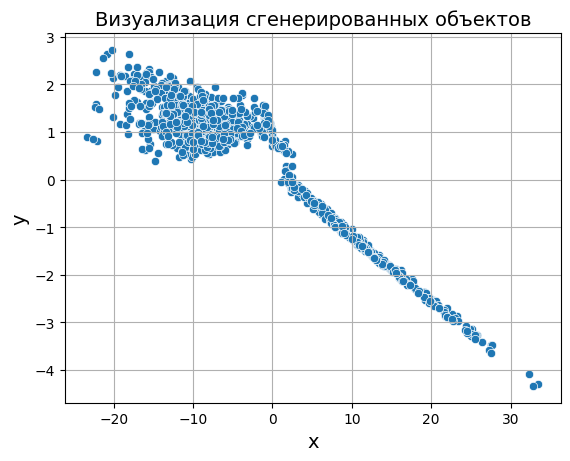

In [26]:
# Визуализация сгенерированных объектов.
sns.scatterplot(
    x=final_data[:, 0],
    y=final_data[:, 1]
)

plt.grid()

plt.title('Визуализация сгенерированных объектов', fontdict={'size': 14})
plt.xlabel('x', fontdict={'size': 14})
plt.ylabel('y', fontdict={'size': 14});

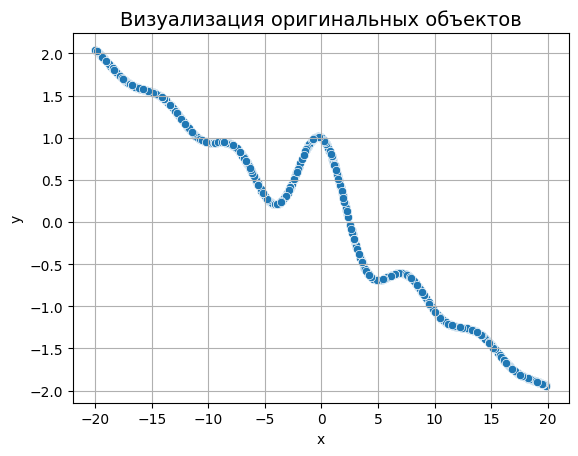

In [27]:
# Визуализация оригинальных объектов.
sns.scatterplot(
    x=df_d['x'],
    y=df_d['y']
)

plt.grid()

plt.title('Визуализация оригинальных объектов', fontdict={'size': 14});

В ходе парного обучения Генератора и Дискриминатора удалось достичь баланса функций потерь обеих нейронных сетей, для этого потребовалось:
- подобрать достаточное количество эпох, равное 100;
- подобрать удачный размер батча, равный 10;
- многократно усовершенствовать Генератор, так как он значительно уступал Дискриминатору.

Для получения лучшего качества прогноза потребуется дальнейшая модернизация моделей, что приведёт к росту потребляемых вычислительных мощностей. В настоящий момент Генератор способен воспроизвести только основную тенденцию графика, однако этого достаточно, чтобы получить равную функцию потерь с Дискриминатором.